# X-Unet V3_3
Training condition: 
- Pre-train thw U-Net with XPIE grayscale dataset (Train-test-split of 0.8)
    - Learning rate 1e-5, trained with 100 epochs
- Fine-tune with 400 LUS, with 5-fold cross validation
    - Learning rate 5e-6, trained with 100 epochs

In [ ]:
%cd G:\My Drive\Lung_Segmentation

g:\My Drive\Lung_Segmentation


In [ ]:
from DataPreprocessing import *
from ValidationAndPrediction import * 
from Model import *
import os
import re
import numpy as np
import pandas as pd
import natsort
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

In [ ]:
tf.__version__

'2.6.0'

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6943781898867832250
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10095296512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3631942980799496899
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# 1. Load the U-Net model


use function `unet_model_v3`:

In [ ]:
width = 256
height = 256
channel = 3

input_shape = (height, width, channel)
pretrain_unet = unet_model_v3(input_shape)
pretrain_unet.summary()

(None, 32, 32, 512)
(None, 64, 64, 256)
(None, 128, 128, 128)
(None, 256, 256, 64)
(None, 256, 256, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]           

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


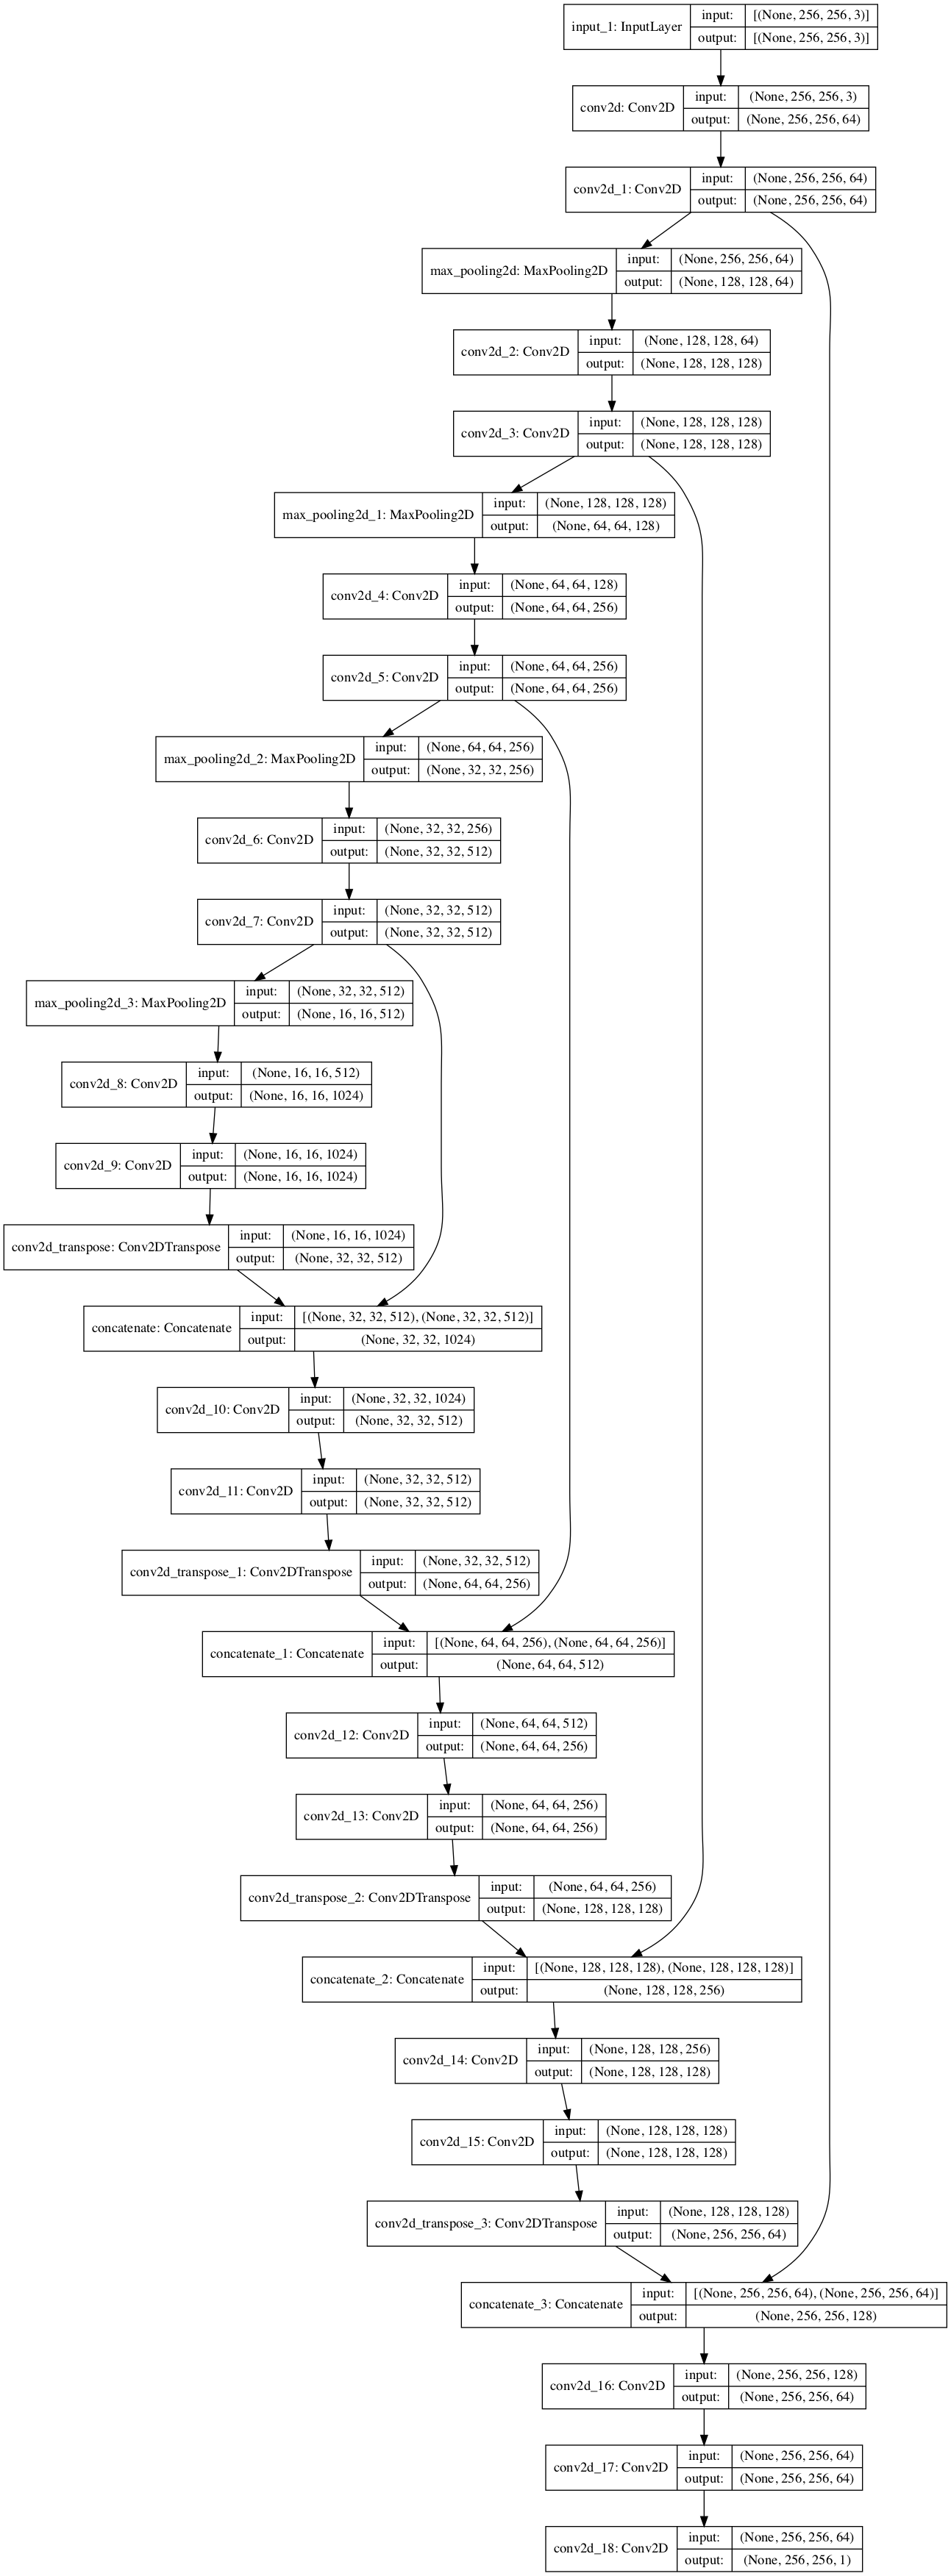

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(pretrain_unet,to_file='v3_pretrain_unet_struct.png',show_shapes=True, show_layer_names=True)

from IPython.display import Image as IP_Image
IP_Image(retina=True, filename='v3_pretrain_unet_struct.png')

# 2. Data Exploration (of XPIE images) 
XPIE dataset is used for pre-training the U-Net

**Preparing the pre-training dataset list: split them into train and test set**

In [ ]:
# Redefine the input size of the images 
width = 256
height = 256
channel = 3

In [ ]:
from sklearn.model_selection import train_test_split

xpie_df = pd.read_csv('XPIE/xpie_gray_filepaths.csv')
# Delete the first column that store the index from data list
xpie_df.drop(xpie_df.columns[0], axis=1, inplace=True)

pretrain_df, pretest_df = train_test_split(xpie_df, train_size=0.8, shuffle=True)
display(pretrain_df)
display(pretest_df)

,filename,mask
4116,XPIE/GrayImages/Y_I_3541.png,XPIE/Grounds/Y_I_3541.png
2193,XPIE/GrayImages/Y_I_1618.png,XPIE/Grounds/Y_I_1618.png
8133,XPIE/GrayImages/Y_I_7558.png,XPIE/Grounds/Y_I_7558.png
7478,XPIE/GrayImages/Y_I_6903.png,XPIE/Grounds/Y_I_6903.png
5411,XPIE/GrayImages/Y_I_4836.png,XPIE/Grounds/Y_I_4836.png
...,...,...
4026,XPIE/GrayImages/Y_I_3451.png,XPIE/Grounds/Y_I_3451.png
7378,XPIE/GrayImages/Y_I_6803.png,XPIE/Grounds/Y_I_6803.png
6280,XPIE/GrayImages/Y_I_5705.png,XPIE/Grounds/Y_I_5705.png
4333,XPIE/GrayImages/Y_I_3758.png,XPIE/Grounds/Y_I_3758.png


,filename,mask
5672,XPIE/GrayImages/Y_I_5097.png,XPIE/Grounds/Y_I_5097.png
3808,XPIE/GrayImages/Y_I_3233.png,XPIE/Grounds/Y_I_3233.png
366,XPIE/GrayImages/Y_E_367.png,XPIE/Grounds/Y_E_367.png
1772,XPIE/GrayImages/Y_I_1197.png,XPIE/Grounds/Y_I_1197.png
9005,XPIE/GrayImages/Y_I_8430.png,XPIE/Grounds/Y_I_8430.png
...,...,...
9746,XPIE/GrayImages/Y_P_372.png,XPIE/Grounds/Y_P_372.png
9508,XPIE/GrayImages/Y_P_134.png,XPIE/Grounds/Y_P_134.png
8913,XPIE/GrayImages/Y_I_8338.png,XPIE/Grounds/Y_I_8338.png
5929,XPIE/GrayImages/Y_I_5354.png,XPIE/Grounds/Y_I_5354.png


In [ ]:
img1 = Image.open('XPIE/GrayImages/Y_E_1.png')
img1 = np.array(img1)
print(img1.shape)

(375, 500)


# 3. Pretrain the network with XPIE images 


Pretrain the model!


C:\Users\Wisely\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\Wisely\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 8000 validated image filenames.
Found 8000 validated image filenames.
Epoch 1/100
333/333 [==============================] - ETA: 0s - loss: -0.3551 - iou: 0.2190 - dice_coef: 0.3552 - binary_accuracy: 0.3355Found 2000 validated image filenames.
Found 2000 validated image filenames.
333/333 [==============================] - 295s 883ms/step - loss: -0.3551 - iou: 0.2190 - dice_coef: 0.3552 - binary_accuracy: 0.3355 - val_loss: -0.4817 - val_iou: 0.3182 - val_dice_coef: 0.4817 - val_binary_accuracy: 0.6967

Epoch 00001: val_loss improved from inf to -0.48173, saving model to model_v3_3\pretrain_localGPU_xpie_unet_lungseg_v3_3.hdf5
Epoch 2/100
333/333 [==============================] - 282s 846ms/step - loss: -0.5021 - iou: 0.3362 - dice_coef: 0.5022 - binary_accuracy: 0.7249 - val_loss: -0.5228 - val_iou: 0.3544 - val_dice_coef: 0.5228 - val_binary_accuracy: 0.7708

Epoch 00002: val_loss improved from -0.48173 to -0.52277, saving model to model_v3_3\pretrain_localGPU_xpie_unet_lun

C:\Users\Wisely\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 2000 validated image filenames.
Found 2000 validated image filenames.
Accuracies :  [0.8824392557144165]
Losses :  [-0.7188541293144226]
Dice coefficients :  [0.7188540101051331]
IOUs :  [0.5627658367156982]


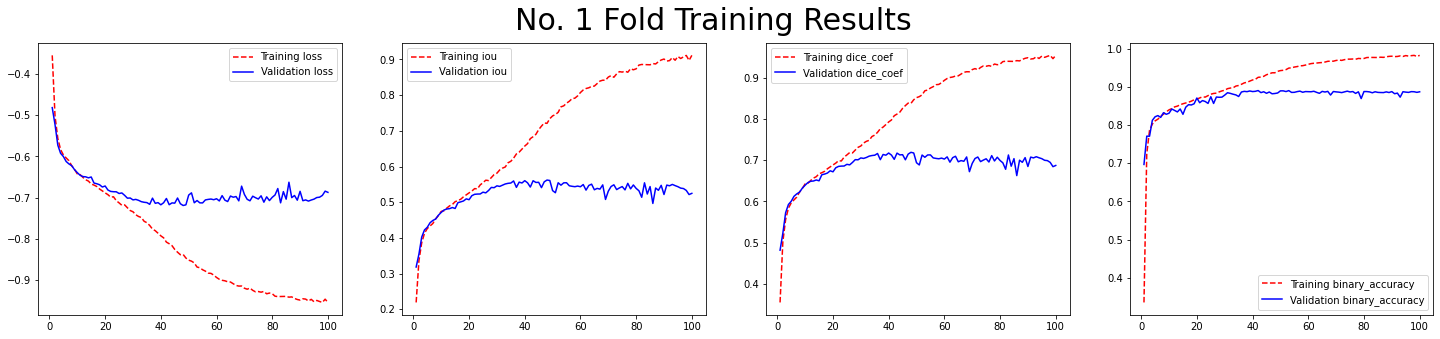

In [ ]:
batch_size = 30
epochs = 100

histories = []
losses = []
accuracies = []
dicecoefs = []
ious = []

# Defining the train generator and test generator: (Don't need data augmentation)
train_gen = train_generator(pretrain_df, batch_size, 
                          None, 
                          dict(), 
                          None, None, None, None, None, 
                          (height, width))

test_gen = train_generator(pretest_df, batch_size,
                           None, 
                           dict(),
                           None, None, None, None, None, 
                           (height, width))

# Train the model with `.fit_generator()`
pretrain_unet.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, 
                    metrics=[iou, dice_coef, 'binary_accuracy'])

checkpoint_path = 'X_Unet/model_v3_3/pretrain_localGPU_xpie_unet_lungseg_v3_3.hdf5'

model_checkpoint = ModelCheckpoint(checkpoint_path,  
                                    verbose=1,
                                    monitor='val_loss',
                                    save_best_only=True)

csvlogger = CSVLogger(filename='X_Unet/model_v3_3/pretrain_localGPU_traininglog_v3_3.csv', separator=",", append=True)

callbacks_list = [model_checkpoint, csvlogger]

history = pretrain_unet.fit_generator(train_gen,
                                    steps_per_epoch=len(xpie_df)//batch_size,
                                    epochs=epochs,
                                    callbacks=callbacks_list,
                                    validation_data = test_gen, 
                                    validation_steps = len(pretest_df)//batch_size,
                                    verbose=1)

PTmodel = load_model(checkpoint_path, 
                    custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
PTmodel.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])


# another generator for evaluate_generator 
evaluate_gen = train_generator(pretest_df, batch_size,
                                None,
                                dict(),
                                None, None, None, None, None,
                                (height, width))

results = PTmodel.evaluate_generator(evaluate_gen, 
                                  steps=len(pretest_df)//batch_size)
results = dict(zip(PTmodel.metrics_names,results))

histories.append(history)
accuracies.append(results['binary_accuracy'])
losses.append(results['loss'])
dicecoefs.append(results['dice_coef'])
ious.append(results['iou'])


plot_histories(histories)

print('Accuracies : ', accuracies)
print('Losses : ', losses)
print('Dice coefficients : ', dicecoefs)
print('IOUs : ', ious)

# 4. Dealing with LUS - Data Preparation 



In [ ]:
train_image_path = 'Lung_seg_data/NEW_TIF_IMG'
train_mask_path = 'Lung_seg_data/NEW_TIF_MASK'
train_images, train_masks = train_filepath_list(train_image_path, train_mask_path)
print('Number of train images: ', len(train_images))
print('Number of train masks: ', len(train_masks))

Number of train images:  200
Number of train masks:  200


Image shape:  (960, 128)
Mask shape:  (960, 128)


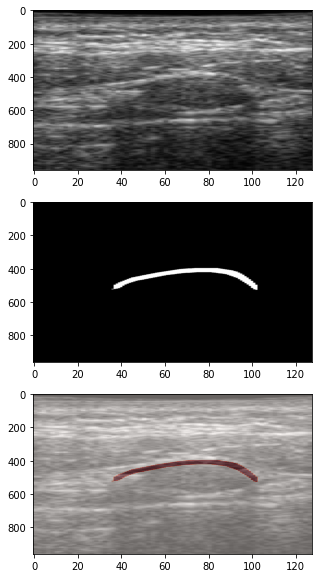

In [ ]:
image_display(train_images, train_masks, 0)

In [ ]:
gen_image_path = 'Lung_seg_data/NEW_CODES/newcode_gen_images'
gen_mask_path = 'Lung_seg_data/NEW_CODES/newcode_gen_masks'
gen_images, gen_masks = train_filepath_list(gen_image_path, gen_mask_path)
print('Number of train images: ', len(gen_images))
print('Number of train masks: ', len(gen_masks))
print(gen_images)

Number of train images:  200
Number of train masks:  200
['Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_5_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_10_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_15_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_20_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_25_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_30_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_35_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_40_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_45_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_50_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_105_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_110_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_115_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_120_flipped.tif', 'Lung_seg_data/XPIEUS/gen_images/img_lung_p

Display one of the flipped images and masks as example

Image shape:  (960, 128, 3)
Mask shape:  (960, 128, 3)


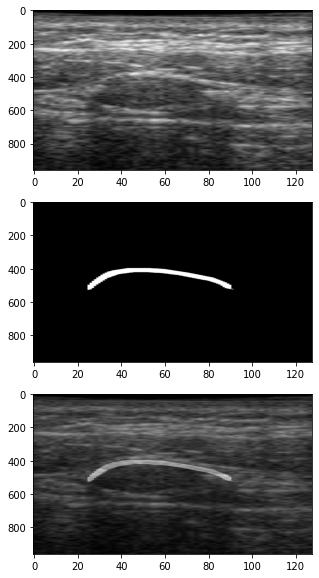

In [ ]:
image_display(gen_images, gen_masks, 0)

**Creating a pandas Dataframe for all the filepaths of both original and generated dataset**
- use function `train_dataframe`

In [ ]:
aug_images = train_images + gen_images
aug_masks = train_masks + gen_masks

US_df = train_dataframe(aug_images, aug_masks)
display(US_df)

,filename,mask
0,Lung_seg_data/XPIEUS/gen_images/img_lung_pos3_...,Lung_seg_data/XPIEUS/gen_masks/mask_lung_pos3_...
1,Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_...,Lung_seg_data/XPIEUS/gen_masks/mask_lung_pos2_...
2,Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_...,Lung_seg_data/XPIEUS/gen_masks/mask_lung_pos2_...
3,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_605.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_605.tif
4,Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_...,Lung_seg_data/XPIEUS/gen_masks/mask_lung_pos2_...
...,...,...
395,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_430.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_430.tif
396,Lung_seg_data/NEW_TIF_IMG/img_lung_pos2_150.tif,Lung_seg_data/NEW_TIF_MASK/mask_lung_pos2_150.tif
397,Lung_seg_data/XPIEUS/gen_images/img_lung_pos2_...,Lung_seg_data/XPIEUS/gen_masks/mask_lung_pos2_...
398,Lung_seg_data/XPIEUS/gen_images/img_lung_pos3_...,Lung_seg_data/XPIEUS/gen_masks/mask_lung_pos3_...


**Use `ImageDataGenerator` for data augmentation**
- use function `train_generator`
- can generate images and masks at the same time using the same seed for the image and masks generators to ensure same transformation between corresponding images and masks 
- to be used in model training process

In [ ]:
# Defining data augmentation dictionary 
train_generator_args = dict(rotation_range=0.15,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

# Redefine the input size of the images 
width = 256
height = 256
channel = 3

# To visualize the results of generator: set save_to_dir = "your path"
aug_img_dir = None
aug_mask_dir = None
aug_img_prefix = None
aug_mask_prefix = None
aug_format = None

# 5. Fine tune the model with LUS


In [ ]:
input_shape = (height, width, channel)

checkpoint_path = 'X_Unet/model_v3_3/pretrain_localGPU_xpie_unet_lungseg_v3_3.hdf5'

FTmodel = load_model(checkpoint_path, 
                    custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

FTmodel.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Display the layers status (trainable or non-trainable)

In [ ]:
# Model groups layers into an object with training and inference features
layers = [(layer, layer.name, layer.trainable) for layer in FTmodel.layers]
FTmodel_df = pd.DataFrame(layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

display(FTmodel_df)

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,True
1,<keras.layers.convolutional.Conv2D object at 0...,conv2d,True
2,<keras.layers.convolutional.Conv2D object at 0...,conv2d_1,True
3,<keras.layers.pooling.MaxPooling2D object at 0...,max_pooling2d,True
4,<keras.layers.convolutional.Conv2D object at 0...,conv2d_2,True
5,<keras.layers.convolutional.Conv2D object at 0...,conv2d_3,True
6,<keras.layers.pooling.MaxPooling2D object at 0...,max_pooling2d_1,True
7,<keras.layers.convolutional.Conv2D object at 0...,conv2d_4,True
8,<keras.layers.convolutional.Conv2D object at 0...,conv2d_5,True
9,<keras.layers.pooling.MaxPooling2D object at 0...,max_pooling2d_2,True


**Fine-tune the model with US images! (with KFold)**

Splitting the dataset: 80% for training, 20% for validation and testing

C:\Users\Wisely\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\Wisely\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


------------------------------------------------------------------------
Training for fold  1
Found 320 validated image filenames.
Found 320 validated image filenames.
Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: -0.3382 - iou: 0.2090 - dice_coef: 0.3382 - binary_accuracy: 0.9530Found 80 validated image filenames.
Found 80 validated image filenames.
16/16 [==============================] - 14s 846ms/step - loss: -0.3382 - iou: 0.2090 - dice_coef: 0.3382 - binary_accuracy: 0.9530 - val_loss: -0.5125 - val_iou: 0.3446 - val_dice_coef: 0.5125 - val_binary_accuracy: 0.9817

Epoch 00001: val_loss improved from inf to -0.51245, saving model to model_v3_3\1KF_finetune_localGPU_xpie_unet_lungseg_v3_3.hdf5
Epoch 2/100
16/16 [==============================] - 9s 599ms/step - loss: -0.5491 - iou: 0.3791 - dice_coef: 0.5491 - binary_accuracy: 0.9799 - val_loss: -0.6063 - val_iou: 0.4350 - val_dice_coef: 0.6063 - val_binary_accuracy: 0.9841

Epoch 00002: val_loss improved fr

C:\Users\Wisely\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 80 validated image filenames.
Found 80 validated image filenames.
------------------------------------------------------------------------
Training for fold  2
Found 320 validated image filenames.
Found 320 validated image filenames.
Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: -0.4019 - iou: 0.2583 - dice_coef: 0.4019 - binary_accuracy: 0.9670Found 80 validated image filenames.
Found 80 validated image filenames.
16/16 [==============================] - 11s 623ms/step - loss: -0.4019 - iou: 0.2583 - dice_coef: 0.4019 - binary_accuracy: 0.9670 - val_loss: -0.5297 - val_iou: 0.3605 - val_dice_coef: 0.5297 - val_binary_accuracy: 0.9830

Epoch 00001: val_loss improved from inf to -0.52970, saving model to model_v3_3\2KF_finetune_localGPU_xpie_unet_lungseg_v3_3.hdf5
Epoch 2/100
16/16 [==============================] - 10s 602ms/step - loss: -0.5891 - iou: 0.4182 - dice_coef: 0.5891 - binary_accuracy: 0.9825 - val_loss: -0.6056 - val_iou: 0.4344 - val_dice_coef

,Accuracy,Loss,Dice coef,IOU
0,0.992613,-0.821745,0.821745,0.697474
1,0.992035,-0.810004,0.810004,0.680795
2,0.992065,-0.818810,0.818810,0.693655
3,0.992270,-0.816663,0.816663,0.690364
4,0.991952,-0.803669,0.803669,0.671928


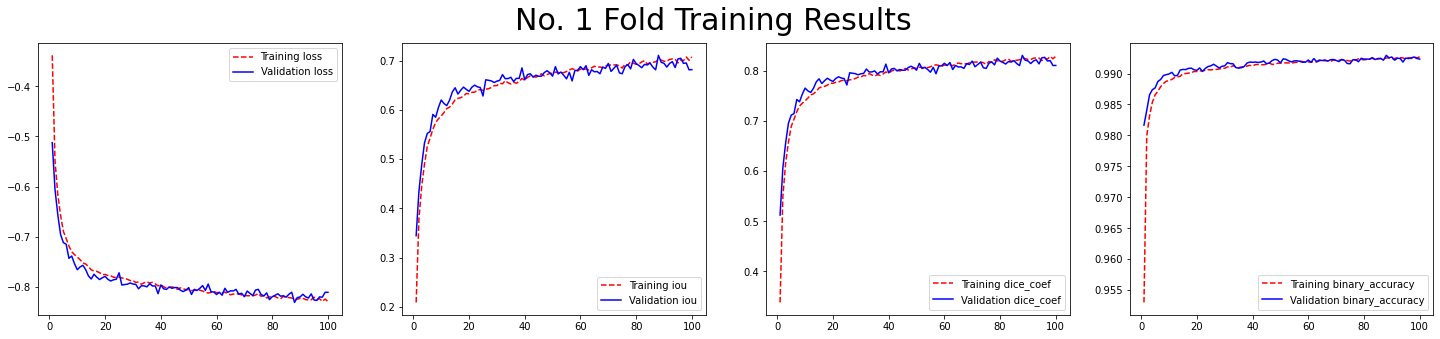

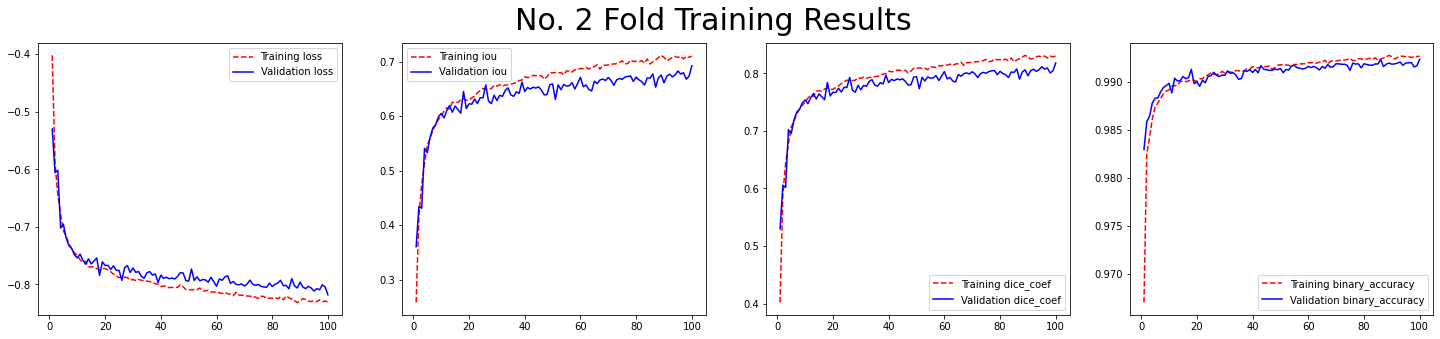

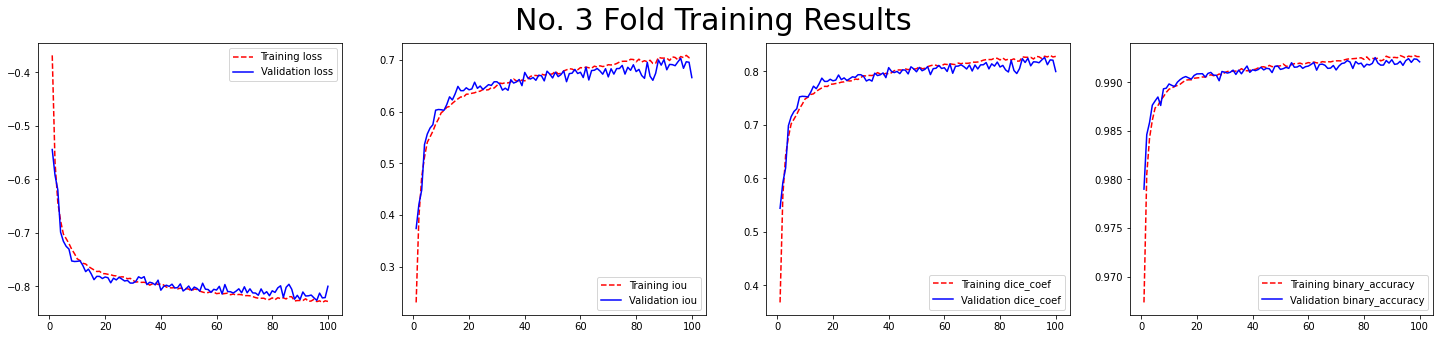

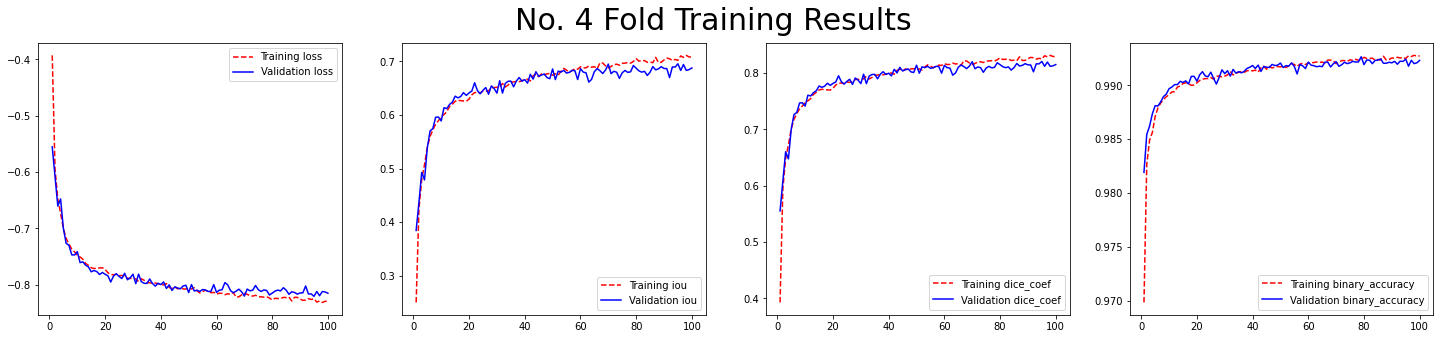

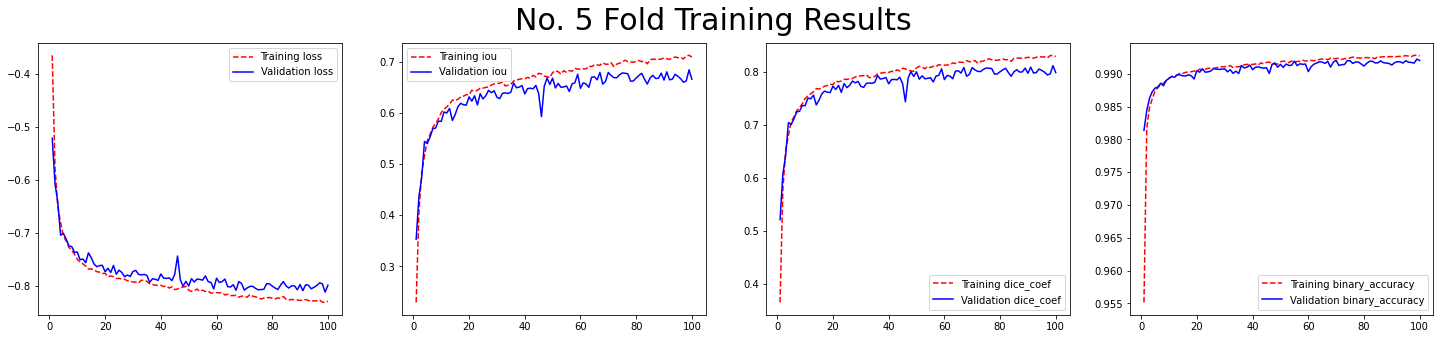

In [ ]:
kf_histories = []
kf_losses = []
kf_accuracies = []
kf_dicecoefs = []
kf_ious = []

# same batch size and epochs
epochs = 100
batch_size = 20

# added KFold in here:
kf = KFold(n_splits = 5, shuffle=True)

for k, (train_index, test_index) in enumerate(kf.split(US_df)):
    kf_train_df = US_df.iloc[train_index]
    kf_test_df = US_df.iloc[test_index]
    
    kf_train_gen = train_generator(kf_train_df, batch_size, 
                                None, 
                                train_generator_args,
                                None, None, None, None, None,
                                (height, width))

    kf_test_gen = train_generator(kf_test_df, batch_size,
                               None, 
                               dict(),
                               None, None, None, None, None, 
                               (height, width))
    
    FTmodel = load_model(checkpoint_path, 
                    custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
    FTmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                metrics=[iou, dice_coef, 'binary_accuracy'])
    
    kf_checkpoint_path = 'X_Unet/model_v3_3/' + str(k+1) + 'KF_finetune_localGPU_xpie_unet_lungseg_v3_3.hdf5'

    kf_model_checkpoint = ModelCheckpoint(kf_checkpoint_path,
                                         verbose=1, 
                                         monitor='val_loss',
                                         save_best_only=True)

    kf_csvlogger = CSVLogger(filename='X_Unet/model_v3_3/'+ str(k+1) +'KF_finetune_loclGPU_xpie_traininglog_v3_3.csv', separator=",", append=True)
    
    kf_callbacks_list = [kf_model_checkpoint, kf_csvlogger]
    
    print('------------------------------------------------------------------------')
    print('Training for fold ', k+1)
    
    kf_history = FTmodel.fit_generator(kf_train_gen, 
                                       steps_per_epoch=len(kf_train_df)//batch_size,
                                       epochs=epochs,
                                       callbacks=kf_callbacks_list,
                                       validation_data = kf_test_gen, 
                                       validation_steps = len(kf_test_df)//batch_size,
                                       verbose=1)
    
    KFmodel = load_model(kf_checkpoint_path, 
                       custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
    KFmodel.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss,
                    metrics=[iou, dice_coef, 'binary_accuracy'])
    
    
    # another generator for evaluate_generator 
    kf_evaluate_gen = train_generator(kf_test_df, batch_size,
                                   None,
                                   dict(),
                                   None, None, None, None, None,
                                   (height, width))
    
    kf_results = KFmodel.evaluate_generator(kf_evaluate_gen, 
                                      steps=len(kf_test_df)//batch_size)
    kf_results = dict(zip(KFmodel.metrics_names,kf_results))
    
    kf_histories.append(kf_history)
    kf_accuracies.append(kf_results['binary_accuracy'])
    kf_losses.append(kf_results['loss'])
    kf_dicecoefs.append(kf_results['dice_coef'])
    kf_ious.append(kf_results['iou'])


plot_histories(kf_histories)

kf_results_df = pd.DataFrame(data={'Accuracy': kf_accuracies, 'Loss': kf_losses, 'Dice coef': kf_dicecoefs, 'IOU': kf_ious},
                             dtype = np.float64)
kf_results_df.to_csv(path_or_buf='X_Unet/model_v3_3/KF_finetune_results.csv')
display(kf_results_df)

**Evaluation metrics:**

In [ ]:
# Print all the evaluation scores: 
print('Evaluation scores from 5 Fold fine-tuning model:')
print('Accuracies : ', kf_accuracies)
print('Losses : ', kf_losses)
print('Dice coefficients : ', kf_dicecoefs)
print('IOUs : ', kf_ious)

print('')

print('Average accuracy : ', np.mean(np.array(kf_accuracies)))
print('Average loss : ', np.mean(np.array(kf_losses)))
print('Average dice coefficient : ', np.mean(np.array(kf_dicecoefs)))
print('Average IOU : ', np.mean(np.array(kf_ious)))

print('')

print('SD of accuracy : ', np.std(np.array(kf_accuracies)))
print('SD of loss : ', np.std(np.array(kf_losses)))
print('SD of dice coefficient : ', np.std(np.array(kf_dicecoefs)))
print('SD of iou : ', np.std(np.array(kf_ious)))

Evaluation scores from 5 Fold fine-tuning model:
Accuracies :  [0.9926134347915649, 0.992034912109375, 0.9920646548271179, 0.9922698736190796, 0.991952121257782]
Losses :  [-0.8217452168464661, -0.8100040555000305, -0.8188102841377258, -0.8166629076004028, -0.8036687970161438]
Dice coefficients :  [0.8217452168464661, 0.8100040555000305, 0.8188102841377258, 0.8166629076004028, 0.8036687970161438]
IOUs :  [0.6974742412567139, 0.6807946562767029, 0.6936545372009277, 0.6903637647628784, 0.6719284057617188]

Average accuracy :  0.9921869993209839
Average loss :  -0.8141782522201538
Average dice coefficient :  0.8141782522201538
Average IOU :  0.6868431210517884

SD of accuracy :  0.00023747916099830935
SD of loss :  0.006523200941918751
SD of dice coefficient :  0.006523200941918751
SD of iou :  0.00928271185837475
